# Project title: Binary Classification


#### In this project we will be using the given videos stored in a tensor format that holds 18 different categories of objects inside these videos and also extra information such as the bounding boxes of the objects, coordinates, segmentation masks, depth masks,..etc.

* first we will load the data using the method provided by the professor in the given notebook("project.ipynb").

* then we will divide the videos into frames to facilitate dealing with the data.

* then we will extract the categories of the objects for each frame which will be our labels for the classification task.
* we will explore the data and visualize a sample of it to help us decide which class we will use to apply our Binary Classification task.


* after selecting the class we will use,  we will modify the labels to be 1 for the selected class and 0 for the rest of the classes.


* finally we will apply some preprocessing techniques to prepare the data for the classification task.



## import library

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from collections import Counter
from google.colab import drive
from skimage.filters import unsharp_mask
from skimage.color import rgb2gray
from skimage.transform import resize
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage.exposure import equalize_hist
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping

## load data

In [ ]:
drive.mount('/content/drive')
PROJECT_ROOT_DIR = "/content/drive/MyDrive/"
data_path = os.path.join(PROJECT_ROOT_DIR, 'tensorflow_data')
os.makedirs(data_path, exist_ok=True)
print("Using directory: ", data_path)
flow_data_set_linear = tfds.load('elg7186_projectdata/linear_movement_rotate', data_dir=data_path)
flow_data_set_rotation = tfds.load('elg7186_projectdata/rotation_rotate', data_dir=data_path)
flow_data_set_fixed = tfds.load('elg7186_projectdata/fixed_random_rotate', data_dir=data_path)

Mounted at /content/drive
Using directory:  /content/drive/MyDrive/tensorflow_data


In [ ]:
# this function is used to make a dataframe from the tensorflow dataset by iterating through the videos then take the frames
# for each video and append them to the dataframe with the corresponding categories

def make_df(data_set):
    df = pd.DataFrame()
    iter_data = iter(data_set['train'])
    for i in range(len(data_set['train'])):
        train_data = next(iter_data)
        for j in range(len(train_data['video'])):
            df = df.append({'img':np.array(train_data['video'][j, :, :, :])
            ,'y': train_data['instances']['category'].numpy()}, ignore_index=True)
    return df

#create dataframes for each dataset and then concatenate them into one dataframe, in these dataframes we have
# 30 videos with 24 frames each, so we have 720 frames in total for each dataset, we have 3 datasets so we have 2160 frames in total

df_linear = make_df(flow_data_set_linear)  #720 frames
df_fixed = make_df(flow_data_set_fixed)    #720 frames
df_rot = make_df(flow_data_set_rotation)   #720 frames
df = pd.concat([df_linear, df_fixed, df_rot], ignore_index=True)  #2160 frames
df.sample(5)

<ipython-input-3-9ad4f3053dc5>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'img':np.array(train_data['video'][j, :, :, :])
<ipython-input-3-9ad4f3053dc5>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'img':np.array(train_data['video'][j, :, :, :])
<ipython-input-3-9ad4f3053dc5>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'img':np.array(train_data['video'][j, :, :, :])
<ipython-input-3-9ad4f3053dc5>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'img':np.array(train_data['video'][j, :, :, :])
<ipython-input-3-9ad4f3053dc5>:10: FutureWarning: The frame.appe

,img,y
755,"[[[162, 154, 137], [161, 153, 136], [155, 146,...","[6, 13, 0]"
566,"[[[102, 133, 175], [101, 132, 174], [101, 132,...","[6, 13, 14]"
303,"[[[95, 91, 87], [98, 99, 88], [93, 95, 83], [1...","[16, 6, 13]"
1290,"[[[201, 92, 54], [200, 93, 54], [201, 92, 54],...","[6, 16, 16]"
532,"[[[199, 165, 90], [198, 164, 89], [198, 164, 9...",[6]


In [ ]:
# datasets shapes
print(df_linear.shape)
print(df_fixed.shape)
print(df_rot.shape)

(720, 2)
(720, 2)
(720, 2)


## visualizing some examples

In [ ]:
df_rot.sample(5)

,img,y
257,"[[[223, 185, 151], [223, 184, 151], [223, 184,...",[13]
356,"[[[185, 182, 156], [186, 182, 156], [186, 183,...","[6, 14, 14]"
482,"[[[125, 133, 145], [122, 130, 140], [120, 127,...","[6, 14, 3, 16, 6, 14]"
638,"[[[194, 166, 102], [194, 166, 101], [195, 167,...",[6]
256,"[[[222, 183, 149], [221, 182, 147], [222, 184,...",[13]


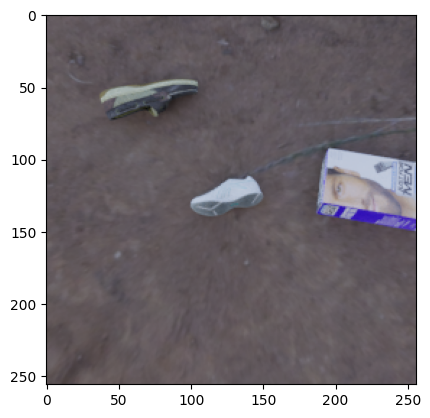

In [ ]:
plt.imshow(np.array(df_rot['img'][426]))

## sample of data

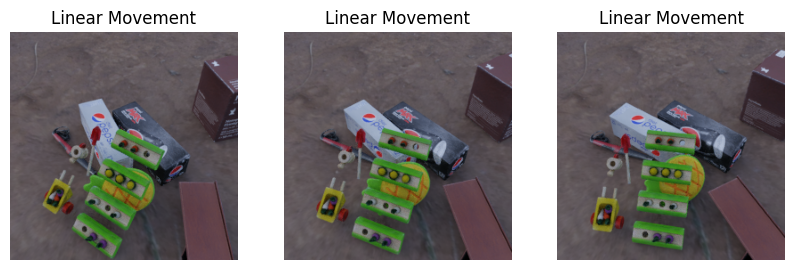

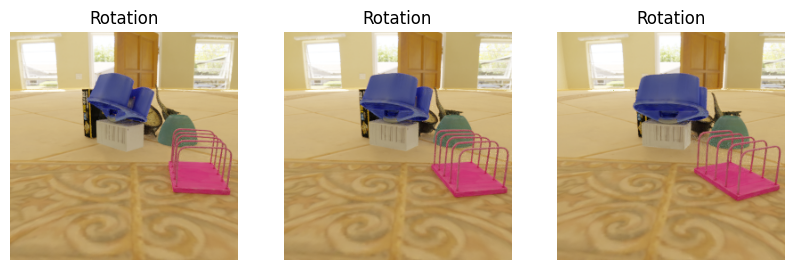

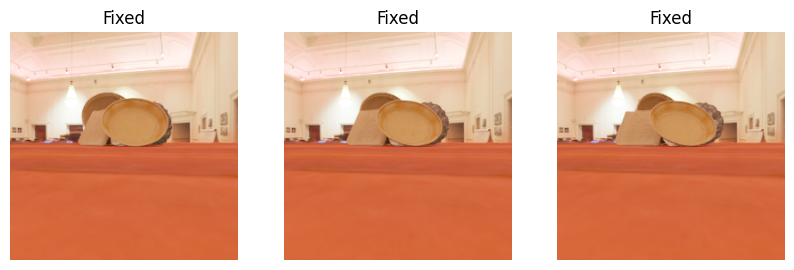

In [ ]:
# in this section we will visualize the data by plotting some images from each dataset to see the difference between them

#linear move dataset
fig, ax = plt.subplots(1, 3, figsize=(10, 10))
ax[0].imshow(df_linear['img'][0])
ax[0].set_title('Linear Movement')
ax[0].axis('off')
ax[1].imshow(df_linear['img'][1])
ax[1].set_title('Linear Movement')
ax[1].axis('off')
ax[2].imshow(df_linear['img'][2])
ax[2].set_title('Linear Movement')
ax[2].axis('off')
plt.show()

# rotation dataset
fig, ax = plt.subplots(1, 3, figsize=(10, 10))
ax[0].imshow(df_rot['img'][0])
ax[0].set_title('Rotation')
ax[0].axis('off')
ax[1].imshow(df_rot['img'][1])
ax[1].set_title('Rotation')
ax[1].axis('off')
ax[2].imshow(df_rot['img'][2])
ax[2].set_title('Rotation')
ax[2].axis('off')
plt.show()


#fixed dataset
fig, ax = plt.subplots(1, 3, figsize=(10, 10))
ax[0].imshow(df_fixed['img'][0])
ax[0].set_title('Fixed')
ax[0].axis('off')
ax[1].imshow(df_fixed['img'][1])
ax[1].set_title('Fixed')
ax[1].axis('off')
ax[2].imshow(df_fixed['img'][2])
ax[2].set_title('Fixed')
ax[2].axis('off')
plt.show()

In [ ]:
# getting the most frequent class to classify based on it to gurantee data balance
from collections import Counter
Counter([item for sublist in df['y'] for item in sublist]).most_common(1)

[(14, 2208)]

## make a copy from the dataframe to keep the original one away from modification

In [ ]:
import copy
df_copy = copy.deepcopy(df)
df_copy['z'] = df_copy['y'].apply(lambda x: 1 if 14 in x else 0)  # 14 is shoe

In [ ]:
df_copy.sample(5)

,img,y,z
683,"[[[211, 192, 132], [211, 192, 132], [211, 192,...","[6, 16, 16, 14, 13, 6, 9]",1
947,"[[[199, 172, 119], [200, 173, 121], [200, 174,...","[3, 14, 6]",1
2079,"[[[193, 166, 101], [193, 165, 99], [193, 164, ...",[6],0
1329,"[[[55, 70, 44], [42, 53, 38], [37, 44, 33], [4...","[6, 14, 3, 14, 0, 6, 9]",1
1586,"[[[33, 25, 17], [33, 25, 19], [32, 23, 18], [3...","[6, 16, 6]",0


## Now we should check for the data balance to avoid any problems that may appear due to data imbalance

Text(0.5, 1.0, 'Histogram of Shoe(1) vs. Non-Shoe(0)')

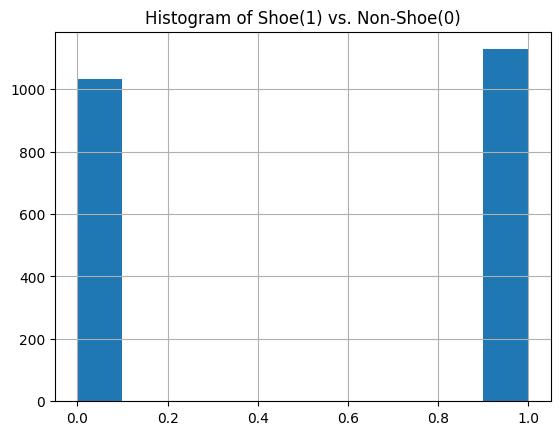

In [ ]:
df_copy['z'].hist()
title = 'Histogram of Shoe(1) vs. Non-Shoe(0)'
plt.title(title)

## As we see the chosen class "shoe" (14) is a great choice for our binary classification problem

## Image preprocessing

In [ ]:
def preprocess_image(img, desired_size=(128, 128)):
    # Resizing
    img = resize(img, desired_size)

    # Enhancing the image using unsharp mask
    img = unsharp_mask(img)

    # Denoising
    sigma_est = np.mean(estimate_sigma(img, multichannel=True))
    img = denoise_nl_means(img, h=1.15 * sigma_est, fast_mode=True, multichannel=True)

    # Histogram Equalization for enhancing contrast
    img = equalize_hist(img)

    # Convert to grayscale
    gray_img = rgb2gray(img)

    # Stack the grayscale image into three channels
    img_3channel = np.stack((gray_img,)*3, axis=-1)

    return img_3channel

# Apply preprocessing to all images
df_copy['processed_img'] = df_copy['img'].apply(preprocess_image)


/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:348: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  return func(*args, **kwargs)
<ipython-input-12-359086c3414b>:9: FutureWarning: `multichannel` is a deprecated argument name for `estimate_sigma`. It will be removed in version 1.0. Please use `channel_axis` instead.
  sigma_est = np.mean(estimate_sigma(img, multichannel=True))
<ipython-input-12-359086c3414b>:10: FutureWarning: `multichannel` is a deprecated argument name for `denoise_nl_means`. It will be removed in version 1.0. Please use `channel_axis` instead.
  img = denoise_nl_means(img, h=1.15 * sigma_est, fast_mode=True, multichannel=True)
/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to

/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:348: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  return func(*args, **kwargs)
<ipython-input-12-359086c3414b>:9: FutureWarning: `multichannel` is a deprecated argument name for `estimate_sigma`. It will be removed in version 1.0. Please use `channel_axis` instead.
  sigma_est = np.mean(estimate_sigma(img, multichannel=True))
<ipython-input-12-359086c3414b>:10: FutureWarning: `multichannel` is a deprecated argument name for `denoise_nl_means`. It will be removed in version 1.0. Please use `channel_axis` instead.
  img = denoise_nl_means(img, h=1.15 * sigma_est, fast_mode=True, multichannel=True)
/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to

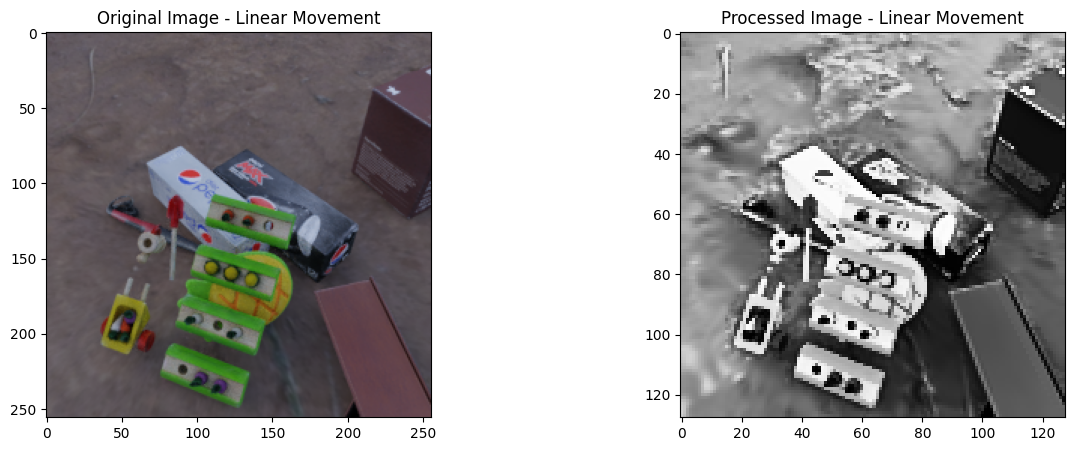

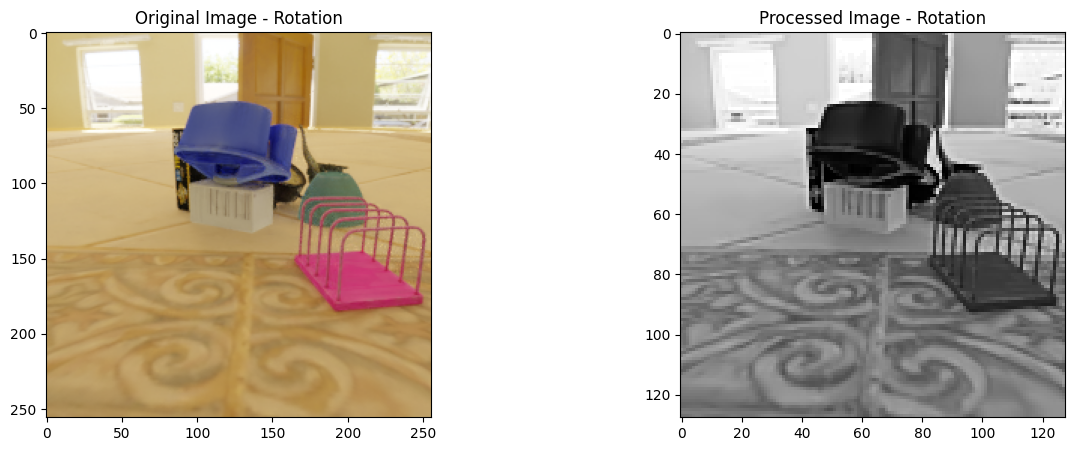

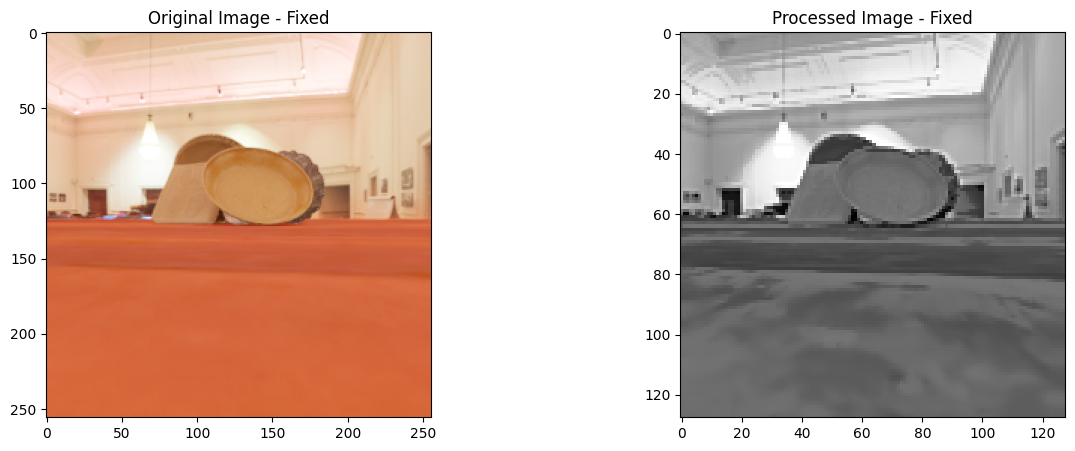

In [ ]:
# this function is used to display the images before and after preprocessing
def display_image_processing(df, title):
      img = df['img'][1]
      processed_img = preprocess_image(img)
      fig, ax = plt.subplots(1, 2, figsize=(15, 5))
      ax[0].imshow(img)
      ax[0].set_title(f"Original Image - {title}")
      ax[1].imshow(processed_img.squeeze(), cmap='gray')
      ax[1].set_title(f"Processed Image - {title}")
      plt.show()

# Display for each dataframe
display_image_processing(df_linear, 'Linear Movement')
display_image_processing(df_rot, 'Rotation')
display_image_processing(df_fixed, 'Fixed')

# Now the data is ready for the training step

In [ ]:
from sklearn.model_selection import train_test_split
# Convert the list of processed images into an array
X = np.array(df_copy['processed_img'].tolist())

# Labels
y = df_copy['z'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Define the model using InceptionV3
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)  # Dropout added
predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)


In [ ]:
model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

In [ ]:
# Train the model with early stopping
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1, callbacks=[early_stopping])


Epoch 1/10
49/49 [==============================] - 7s 151ms/step - loss: 0.0335 - accuracy: 0.9884 - val_loss: 1.4386 - val_accuracy: 0.8382
Epoch 2/10
49/49 [==============================] - 5s 107ms/step - loss: 0.0329 - accuracy: 0.9923 - val_loss: 0.6576 - val_accuracy: 0.9133
Epoch 3/10
49/49 [==============================] - 5s 102ms/step - loss: 0.0367 - accuracy: 0.9846 - val_loss: 0.0173 - val_accuracy: 0.9942
Epoch 4/10
49/49 [==============================] - 5s 105ms/step - loss: 0.0036 - accuracy: 1.0000 - val_loss: 0.0062 - val_accuracy: 0.9942
Epoch 5/10
49/49 [==============================] - 5s 100ms/step - loss: 0.0123 - accuracy: 0.9974 - val_loss: 0.0814 - val_accuracy: 0.9884
Epoch 6/10
49/49 [==============================] - 5s 95ms/step - loss: 0.0094 - accuracy: 0.9974 - val_loss: 0.0108 - val_accuracy: 0.9942
Epoch 7/10
49/49 [==============================] - 5s 102ms/step - loss: 0.0101 - accuracy: 0.9987 - val_loss: 0.1460 - val_accuracy: 0.9595
Epoch 8

In [ ]:
# Predictions for training and testing sets
y_pred_train = model.predict(X_train)
y_pred_train = (y_pred_train > 0.5).astype(int)
y_pred_test = model.predict(X_test)
y_pred_test = (y_pred_test > 0.5).astype(int)

14/14 [==============================] - 2s 25ms/step


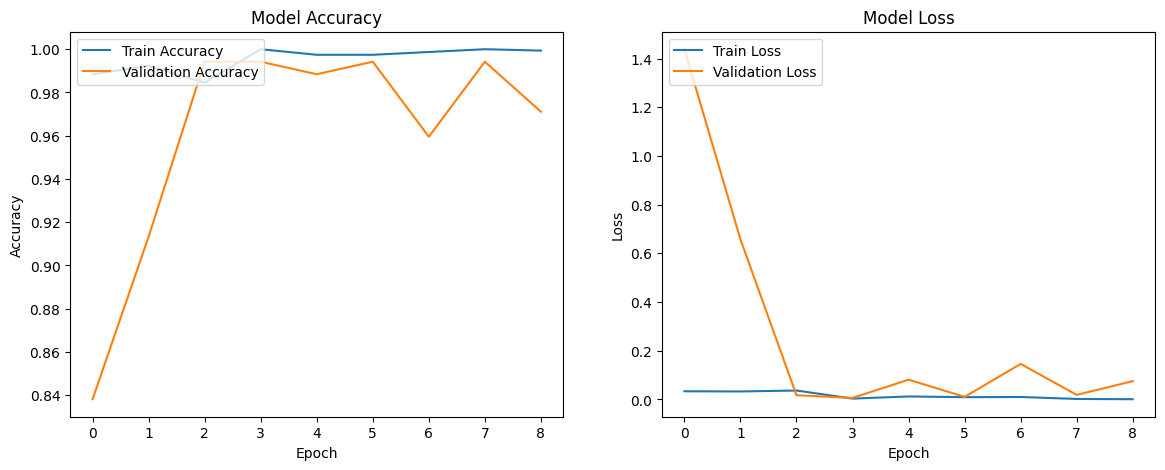

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.show()

Classification Report for Training Set:
              precision    recall  f1-score   support

    Non-Shoe       1.00      1.00      1.00       814
        Shoe       1.00      1.00      1.00       914

    accuracy                           1.00      1728
   macro avg       1.00      1.00      1.00      1728
weighted avg       1.00      1.00      1.00      1728



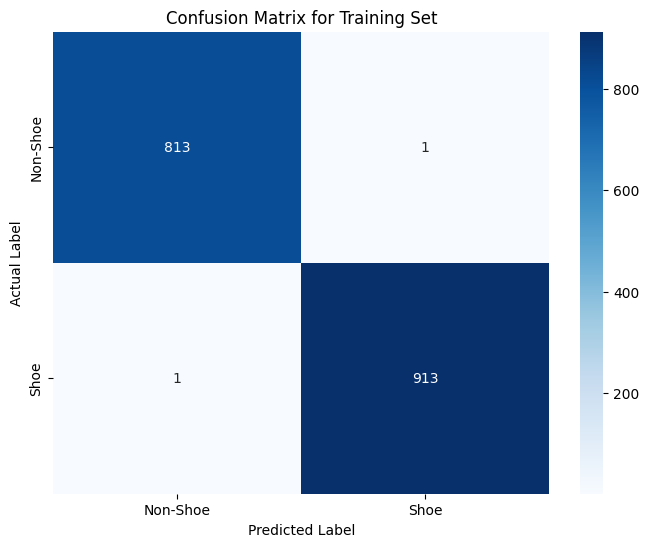

Classification Report for Testing Set:
              precision    recall  f1-score   support

    Non-Shoe       0.99      1.00      0.99       218
        Shoe       1.00      0.99      0.99       214

    accuracy                           0.99       432
   macro avg       0.99      0.99      0.99       432
weighted avg       0.99      0.99      0.99       432



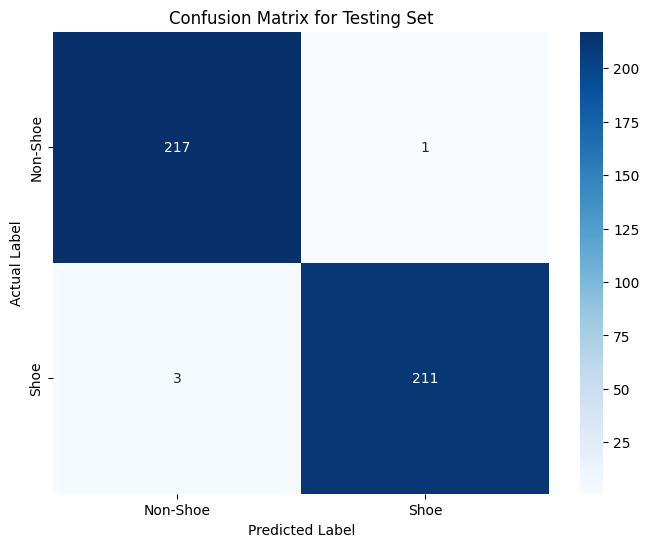

In [ ]:
import seaborn as sns
# Function to plot confusion matrix and print classification report
def evaluate_performance(y_true, y_pred, dataset_type='Training'):
    print(f'Classification Report for {dataset_type} Set:')
    print(classification_report(y_true, y_pred, target_names=['Non-Shoe', 'Shoe']))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Shoe', 'Shoe'], yticklabels=['Non-Shoe', 'Shoe'])
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.title(f'Confusion Matrix for {dataset_type} Set')
    plt.show()

# Evaluate performance on training set
evaluate_performance(y_train, y_pred_train, 'Training')

# Evaluate performance on testing set
evaluate_performance(y_test, y_pred_test, 'Testing')